# Basin scale Evapotranspiration (ET) calulation and comparison, an example of Columbia river basin
### · Conduct ET calculation based on water balance approach
### · Compare the interannual variability (IAV) of GRACE based ET with OpenET and GLEAM products
### · Comapre the IAV of ET on the site scale, a mixed forest site 'US-Me2'

In [1]:
### required packages
import numpy as np
import pandas as pd
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon
import geopandas
from scipy.interpolate import RegularGridInterpolator
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as smpk
from scipy.stats import norm

## 1. Calculate basin ET based on the water balance equation: ET = P - dTWS - runoff
### dTWS: calculated from GRACE/FO total water storage (TWS)
### P: from GPCP products
### runoff: from USGS station data

#### 1.1 dTWS: calculated from GRACE/FO total water storage (TWS)

In [2]:
### Read GRACE data
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
dataset = netCDF4.Dataset('GRCTellus.JPL.200204_202410.GLO.RL06.3M.MSCNv04CRI.nc') 

# shift the data for right display
tmp_lat = dataset.variables['lat'][:]
tmp_lon = dataset.variables['lon'][:]
tmp_TWS = dataset.variables['lwe_thickness'][:]
uncertainty = dataset.variables['uncertainty'][:]
mascon = dataset.variables['mascon_ID'][:]
var_lat = np.flip(tmp_lat) # from [-90,90] to [90,-90]
var_lon = tmp_lon - 180. # from [0,360] to [-180,180]
var_TWS = np.roll(np.flip(tmp_TWS,axis=1),360, axis=2)*10 #from cm to mm
uncertainty = np.roll(np.flip(uncertainty,axis=1),360, axis=2)*10
mascon = np.roll(np.flip(mascon,axis=0),360,axis=1)
date = pd.to_datetime(dataset.variables['time'][:],unit='D',origin=pd.Timestamp('2002-1-1'))

# Get the weighted area in each global cell
area_weights = np.zeros((len(var_lat),len(var_lon))) # This is set to account for different areal extent for each grid cell.
radius = 6371 # km
dlat, dlon = 0.5, 0.5 # each grid cell size is 0.5 degree on the latitude and longitude directions.  
for i in range(len(var_lat)):
    for j in range(len(var_lon)):
        area_weights[i,j] = radius**2*np.cos(np.radians(var_lat[i]))*np.radians(dlat)*np.radians(dlon) #dS = r² sinθ dθ dφ , θ is 90-lat       



#### Visulize one GRACE TWS map

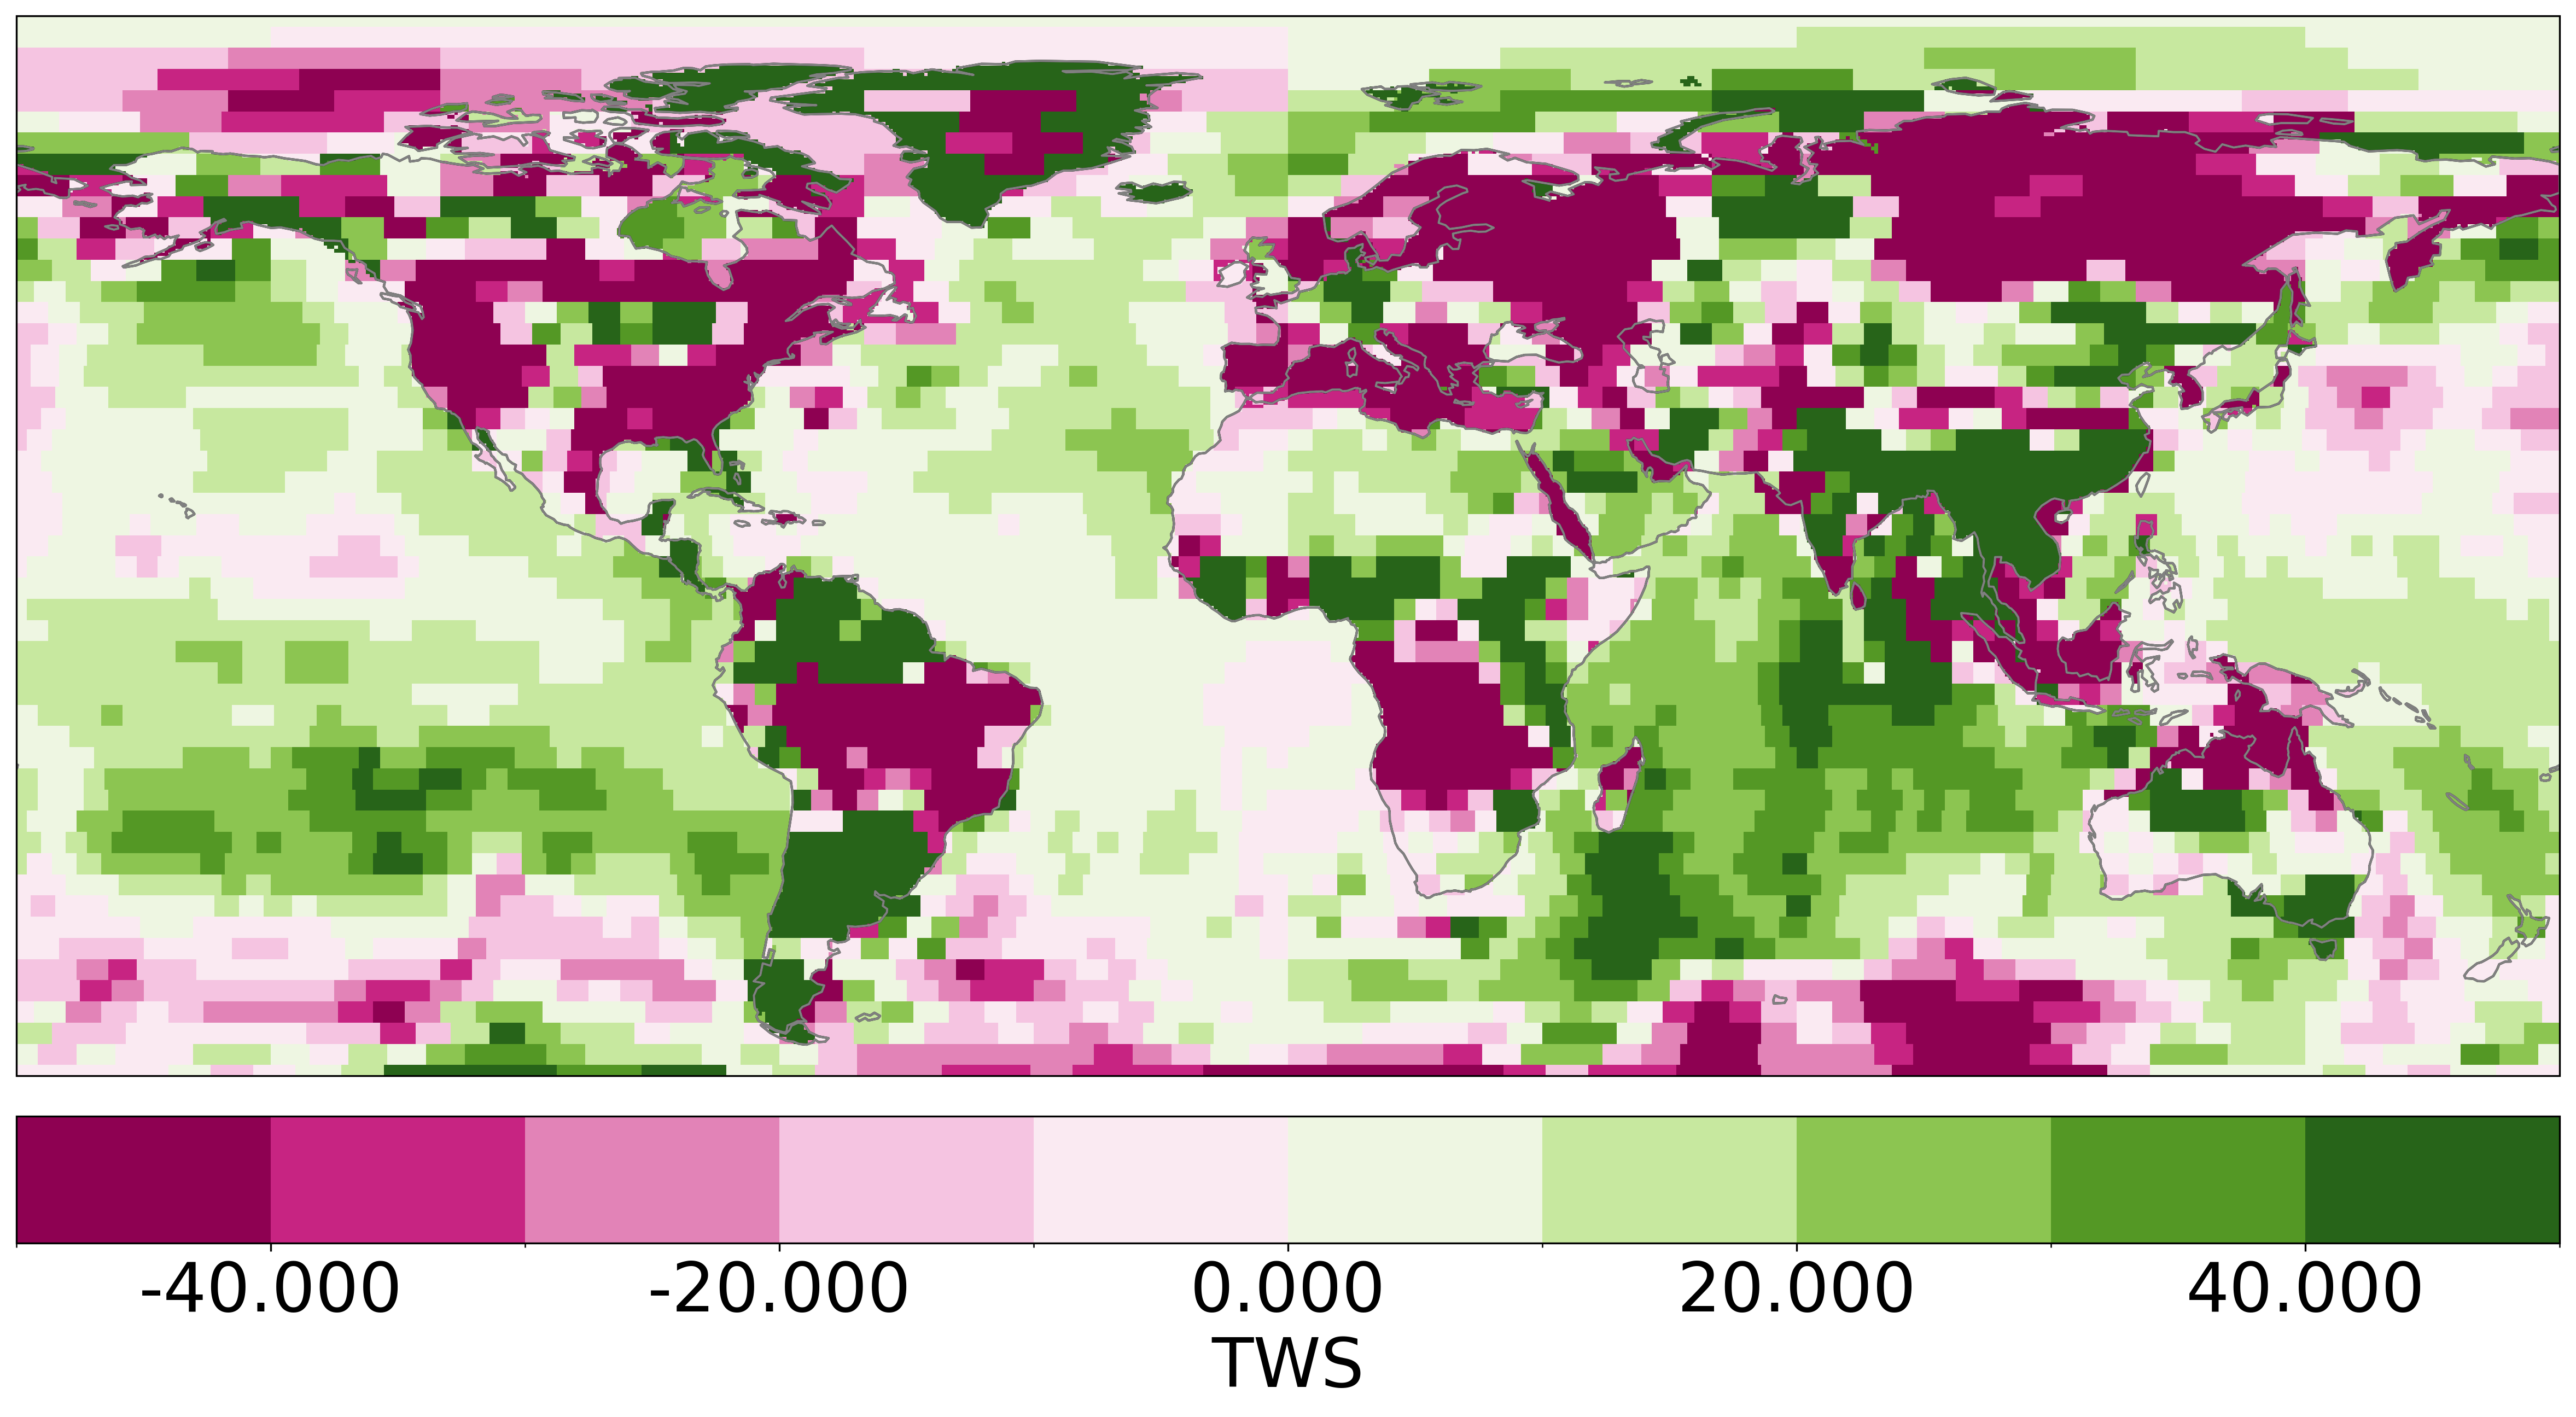

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.feature as cfeature
## visualize spatial data in Python. 
def mapping(tmp,lon,lat,levels,label,cmap,labelformat = '%2.1f'):
    fig = plt.figure(figsize=(20, 16),dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree(),ylim=(-60,90))
    ax.coastlines(color='black')
    norm = mpl.colors.BoundaryNorm(boundaries=levels,ncolors=256)
    img = ax.pcolormesh(lon, lat, tmp,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading='nearest')
    img.cmap.set_bad('white')
    cbar=plt.colorbar(img,ax=ax,location='bottom',format=labelformat,extend=None,pad=0.02)
    cbar.ax.tick_params(labelsize=30)
    cbar.set_label(label=label,fontsize=30)  
    ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature(\
        'physical', 'land', scale="110m",\
        edgecolor='gray', facecolor='none'))

## levels defines the scale of your legend.
levels = np.linspace(-50,50, 11)

## Here is an example of plotting the third month's TWS field. 
mapping(var_TWS[2,:,:],var_lon,var_lat,levels,label=r'TWS', cmap='PiYG',labelformat = '%3.3f')


In [3]:
### Load some functions

## Convert the .shp file for basin to a grided mask array, the pixels within the polygon are 1, others are 0.
def read_basin(filepath):
    from geopandas import GeoDataFrame, GeoSeries
    from shapely.geometry import Point, Polygon
    import geopandas
    ## This file contains the basin boundary that drains to the gauging station. 
    df = geopandas.read_file(filepath)
    lon, lat = -179.875 + np.arange(1440)*0.25, 89.875 - np.arange(720)*0.25
    llon, llat = np.meshgrid(lon,lat)
    flon, flat = llon.flatten(), llat.flatten()
    pts = GeoSeries([Point(x,y) for x,y in zip(flon,flat)])
    in_map = np.array([pts.within(geom) for geom in df.geometry])

    ## This is designed for the shapefile with multiple polygons and merge them together, here we only have one polygon.
    allbasinmask = np.zeros((360,720))
    for i in range(len(in_map)):
        basinmask = in_map[i,:].reshape(720,1440).astype(int)
        basinmask = basinmask.reshape(360,2,720,2)
        basinmask = np.sum(np.sum(basinmask,axis=1),axis=-1)
        basinmask[basinmask>1] = 1
        allbasinmask = allbasinmask+basinmask
    return allbasinmask

## Get the averaged dTWS and dTWS_error of a specific basin
def cal_ds_error(allbasinmask):
    ## Calculate the area-weighted averaged TWS in a basin    
    var1= np.tile(area_weights[allbasinmask==1],(var_TWS.shape[0],1))
    var2 = var_TWS[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
    mask_average = pd.Series(mask_average, date)
    mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
     
    ## Calculate the area-weighted averaged TWS-error in a basin   
    var3= np.tile(area_weights[allbasinmask==1],(uncertainty.shape[0],1))
    var4 = uncertainty[:,allbasinmask==1]
    var3[np.isnan(var4)]=np.nan
    var5 = mascon*allbasinmask
    var5 = var5.filled(np.nan)
    new_var5 = var5.reshape((360*720))
    
    mascon_uncertainty = np.zeros((uncertainty.shape[0]))
    for j in range(var_TWS.shape[0]):
        temp = 0
        for i in list(set(new_var5[:])):
            if i==0:
                continue
            temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))  
        mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
    mascon_uncertainty = pd.Series(mascon_uncertainty, date)
    mascon_uncertainty = mascon_uncertainty.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')

    ## Calculate the dS and the error by centered finite difference approach 
    ds,ds_error1 = central_diff(mask_average,mascon_uncertainty)
    return ds,ds_error1

## Centered finite difference approach: differencing the preceding and following months and dividing by 2ΔT (ΔT is one month)
def central_diff(series,error):
    ds = (np.array(series[2:]) - np.array(series[0:-2]))/2
    ds = pd.Series(ds,index = series.index[1:-1])
    error1 = np.sqrt(np.array(error[2:])**2+np.array(error[0:-2])**2)/2
    error1 = pd.Series(error1,index=error.index[1:-1])
    return ds,error1

#### Call the function to get dTWS and dTWS_error by using centered finite difference approach

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2002-05-01   -37.460013
2002-06-01   -71.848482
2002-07-01   -71.848482
2002-08-01   -50.225877
2002-09-01   -30.599784
                ...    
2024-05-01   -34.398569
2024-06-01   -71.943269
2024-07-01   -74.867647
2024-08-01   -35.230065
2024-09-01   -22.452485
Freq: MS, Length: 269, dtype: float64 2002-05-01    29.209506
2002-06-01    18.148974
2002-07-01    16.504955
2002-08-01    17.814958
2002-09-01    13.176631
                ...    
2024-05-01     8.917402
2024-06-01    10.675166
2024-07-01    12.743614
2024-08-01    15.667997
2024-09-01    19.244464
Freq: MS, Length: 269, dtype: float64


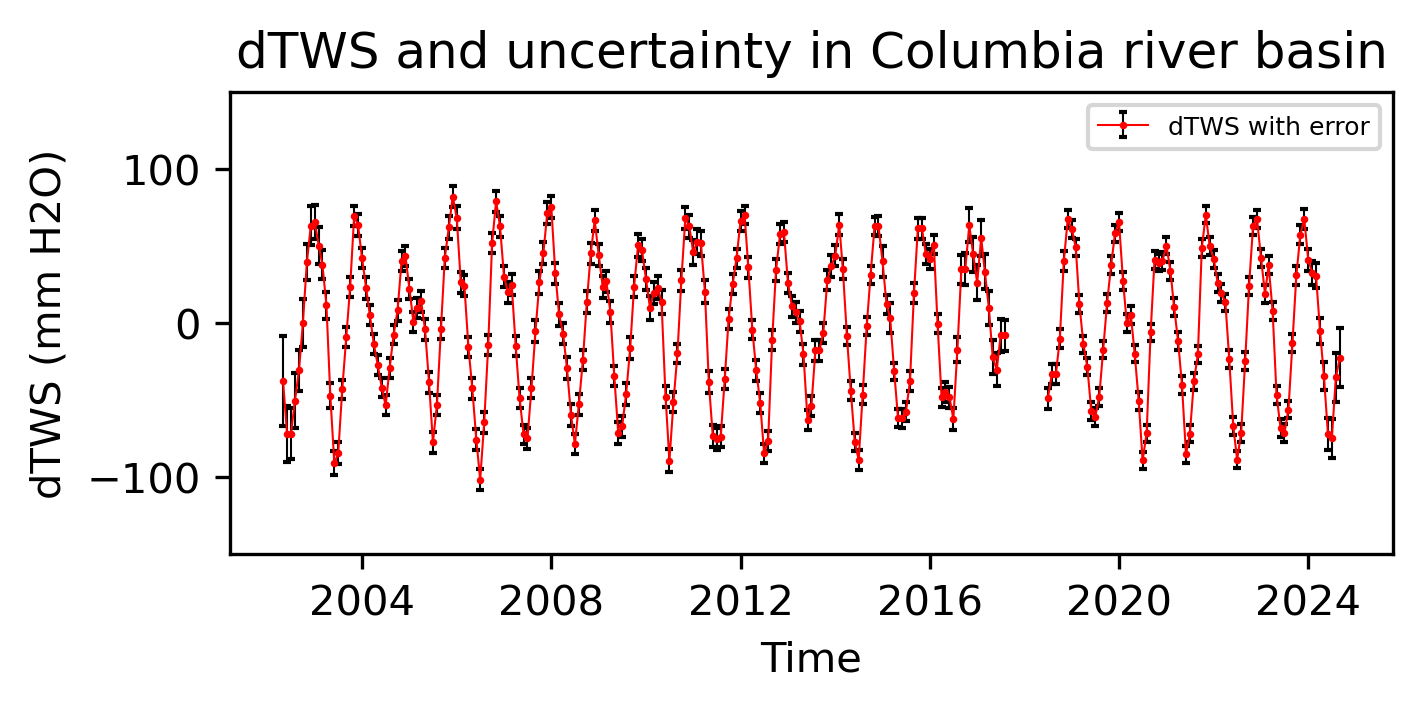

In [4]:
## Read the Columbuia river basin boundary
allbasinmask = read_basin("Columbia.shp")

## calculate the dTWS, dTWS_error
ds_basin,ds_error = cal_ds_error(allbasinmask)
print(ds_basin,ds_error)

plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-150,150)
yerr = np.array(ds_error)
plt.legend(fontsize=6)
plt.errorbar(ds_basin.index, np.array(ds_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='dTWS with error')
plt.xlabel('Time')
plt.ylabel('dTWS (mm H2O)')
plt.title('dTWS and uncertainty in Columbia river basin')
plt.legend(fontsize=6)

#### 1.2 P from GPCP products

In [5]:
## Load the GPCP precipitation data
'''
## These code just shows how to prepare the precipitation dataset from GPCP, don't have to run this.

## Read the GPCP precipitation and error dataset, from the unit (mm/day) to (mm/month)
import netCDF4
pre = np.zeros((288,360,720))*np.nan
pre_uncertain = np.zeros((288,360,720))*np.nan
pre_date = pd.date_range('2000-1-1','2023-12-1',freq='MS')
count = 0
for year in range(2000,2024):
    for mon in range(1,13):
        pre[count,:,:] = netCDF4.Dataset('E:/01Project/01ET/01Data/01GPCP/GPCPMON_L3_{0:04d}{1:02d}_V3.2.nc4'.format(year,mon))['sat_gauge_precip'][:]\
                                *pre_date[count].daysinmonth
        count = count + 1

count = 0
for year in range(2000,2024):
    for mon in range(1,13):
        pre_uncertain[count,:,:] = netCDF4.Dataset('E:/01Project/01ET/01Data/01GPCP/GPCPMON_L3_{0:04d}{1:02d}_V3.2.nc4'.format(year,mon))['sat_gauge_error'][:]\
                                *pre_date[count].daysinmonth
        count = count + 1

'''
## Load the precipitation data from your downloaded file
pre = netCDF4.Dataset('pre_GPCP.nc').variables['pre'][:]
pre.shape
pre_uncertain = netCDF4.Dataset('pre_uncertain_GPCP.nc').variables['pre_uncertain'][:]
pre_uncertain.shape

(288, 360, 720)

In [6]:
## This function calculate the averaged precipitation and error within a specific basin boundary
def cal_pre_error(allbasinmask):
    pre_date = pd.date_range('2000-1-1','2023-12-1',freq='MS')
    var1= np.tile(area_weights[allbasinmask==1],(pre.shape[0],1))
    var2 = pre[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    pre_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)

    var3= np.tile(area_weights[allbasinmask==1],(pre_uncertain.shape[0],1))
    var4 = pre_uncertain[:,allbasinmask==1]
    var3[np.isnan(var4)]=np.nan

    uncertainty_pre_average = np.sqrt(np.nansum((var3**2)*(var4**2),axis=1)/np.nansum(var3,axis=1)**2)

    pre_average = pd.Series(pre_average, pre_date)
    pre_error = pd.Series(uncertainty_pre_average, pre_date)
    return pre_average,pre_error



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


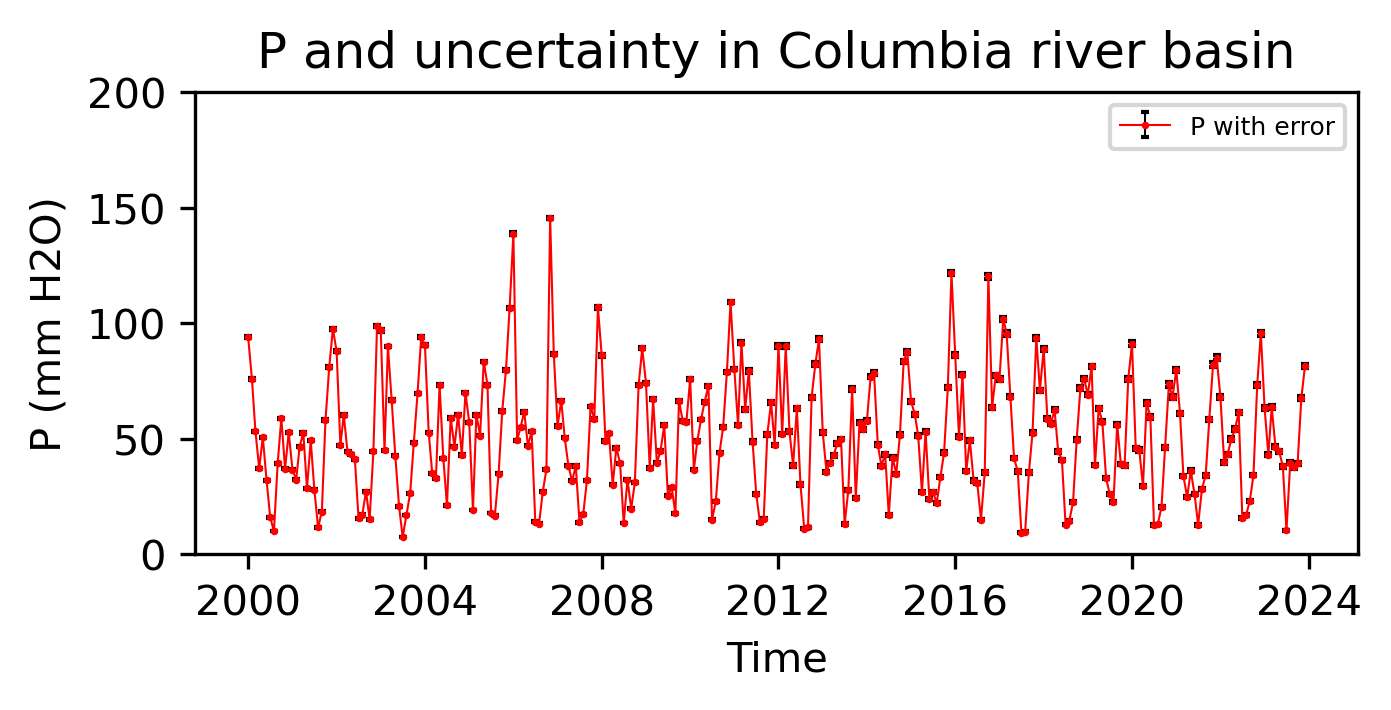

In [7]:
## calculate the precipitation and the error
pre_basin,pre_error = cal_pre_error(allbasinmask)

## Plot the figure
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(0,200)
yerr = np.array(pre_error)
plt.legend(fontsize=6)
plt.errorbar(pre_basin.index, np.array(pre_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='P with error')
plt.xlabel('Time')
plt.ylabel('P (mm H2O)')
plt.title('P and uncertainty in Columbia river basin')
plt.legend(fontsize=6)

#### 1.3 runoff (Q) from USGS station data

In [8]:
## Read the runoff from .txt file downloaded from USGS website for each basin
def read_runoff(filepath): #default setting: from the line 35, read data from 2000-01 to 2023-12
    import numpy as np
    import pandas as pd
    
    # Skip the first 35 lines
    df = pd.read_csv(filepath, skiprows=35,delimiter="\t")
    df.drop(index=0,inplace=True)

    # Extract the period from 2000-02 to 2023-12
    df['year_nu'] = df['year_nu'].astype(int)
    df['month_nu'] = df['month_nu'].astype(int)
    df['mean_va'] = df['mean_va'].astype(float)
    df = df[df['year_nu']>1999]
    df = df[df['year_nu']<2024]

    # Generate the time series
    dates = pd.to_datetime([f"{year}-{month:02d}-01" for year, month in zip(df['year_nu'], df['month_nu'])])
    values = [value for value in df['mean_va']]
    runoff = pd.Series(data=values, index=dates)
    return runoff

## The unit of runoff is cubic feet/second in the raw .txt file, convert it to mm/month
def convert_unit(series, area):# need to provide the area of the basin with the unit of mm^2
    new_series = series
    for i in range(len(series)):
        new_series.iloc[i] = (series.iloc[i]*28316846.592/area)*3600*24*series.index[i].daysinmonth
    return new_series


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


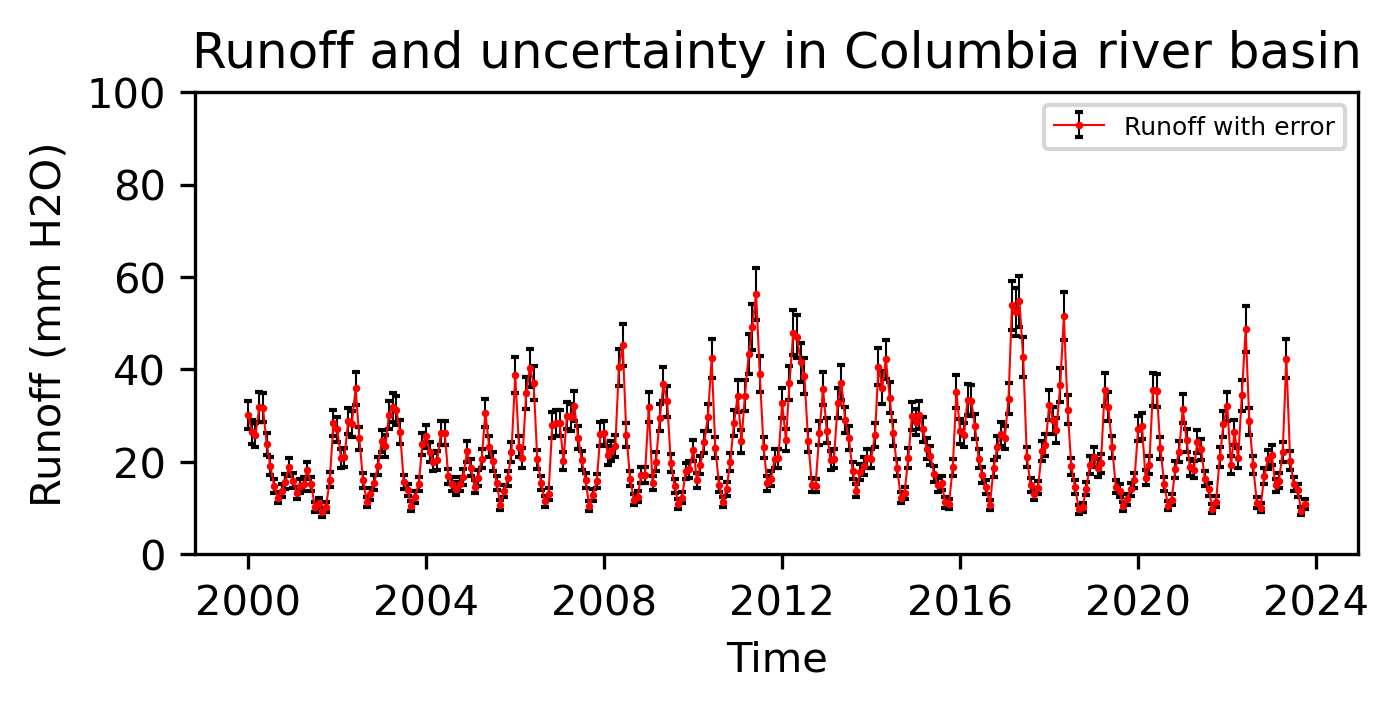

In [9]:
# read the runoff
runoff_total = read_runoff("USGS_14246900.txt")

# Convert the unit to mm/month
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin # the error is 10% of the raw runoff value

plt.figure(figsize=(5,2),dpi=300)
plt.ylim(0,100)
yerr = np.array(runoff_error)
plt.legend(fontsize=6)
plt.errorbar(runoff_basin.index, np.array(runoff_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='Runoff with error')
plt.xlabel('Time')
plt.ylabel('Runoff (mm H2O)')
plt.title('Runoff and uncertainty in Columbia river basin')
plt.legend(fontsize=6)

### 1.4 ET and its error are calcualted as follows: 
### ET = P - dTWS - Q
### σ_ET= √(σ_(dTWS/dt+)^2+σ_P^2+σ_Q^2 )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


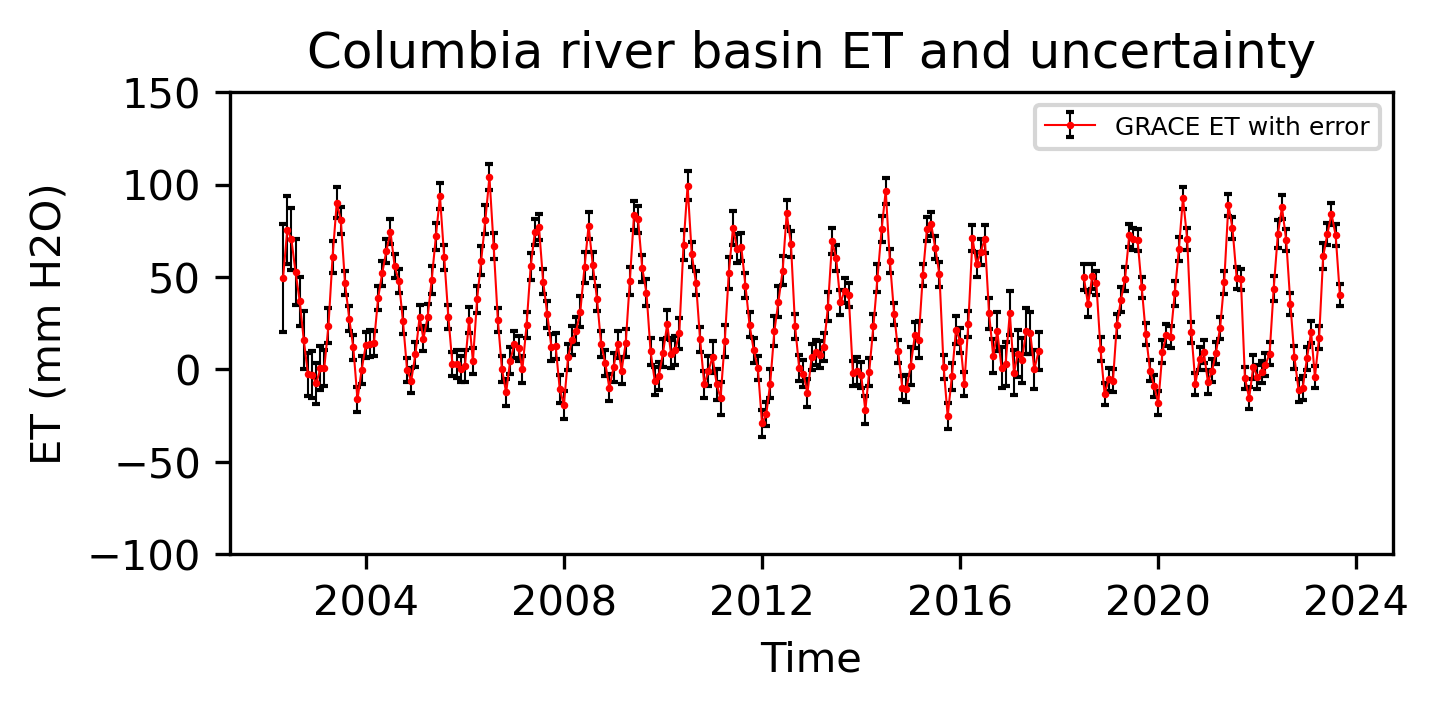

In [10]:
def cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error):
    pre_basin=pre_basin.rolling(window=3, center=True).mean()
    runoff_basin = runoff_basin.rolling(window=3, center=True).mean()
    ET = pre_basin - ds_basin- runoff_basin
    ET_error = np.sqrt(ds_error**2+pre_error**2+runoff_error**2)
    return ET, ET_error

ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)


# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-100,150)
yerr = np.array(ET_error)
plt.legend(fontsize=6)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Columbia river basin ET and uncertainty')
plt.legend(fontsize=6)

## 2. Compare the GRACE-based ET with OpenET and GLEAM ET

#### Load the GLEAM data

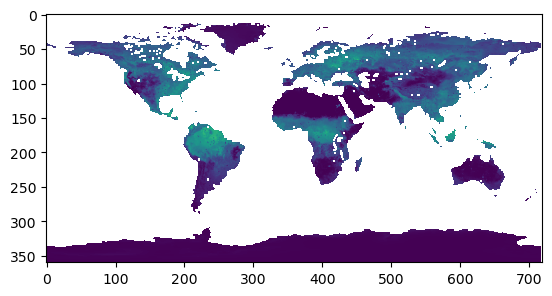

In [11]:
'''
### This code shows how to read GLEAM dataset and resample from 0.1 to 0.5 degree
### reample the data from any resolution to 0.5 degree
def resample(original_data):
    import numpy as np
    from scipy.interpolate import RegularGridInterpolator
    tmp_lon = np.linspace(-180,180,original_data.shape[2])
    tmp_lat = np.linspace(90,-90,original_data.shape[1])
    new_data = np.zeros((original_data.shape[0],360,720))
    for i in range(new_data.shape[0]):
    
        # Target dimensions
        new_x = np.linspace(-180, 180, 720)
        new_y = np.linspace(90, -90, 360)

        # Interpolation function
        interpolator = RegularGridInterpolator((tmp_lon, tmp_lat), original_data[i,:,:].reshape(original_data.shape[1],original_data.shape[2]).T,bounds_error=False,fill_value=None )

        X_new, Y_new = np.meshgrid(new_x, new_y)
        new_points = np.array([X_new.ravel(), Y_new.ravel()]).T

        # Reshape the interpolated values back into the new grid shape
        resized_array = interpolator(new_points).reshape((360,720))
        # New array with target dimensions
        new_data[i,:,:] = resized_array

    return new_data


## Read the GLEAM ET (mm/month)
import netCDF4
gleam= np.zeros((264,360,720))*np.nan

gleam_date = pd.date_range('2002-1-1','2023-12-1',freq='MS')
count = 0
for year in range(2002,2024):
    gleam[count:count+12,:,:] = resample(netCDF4.Dataset('E:/01Project/04ET_assessment/07GLEAM_ET/E_{:04d}_GLEAM_v4.2a_MO.nc'.format(year)).variables['E'][:])
    count = count + 12
'''
## Load the GLEAM data from the downloaded file for this workshop
gleam = netCDF4.Dataset('gleam_ET.nc').variables['gleam_ET'][:]
gleam.shape
plt.imshow(gleam[6,:,:])

In [16]:
def read_gleam(allbasinmask):
    # Calculate the area-weighted averaged TWS in a basin 
    gleam_date = pd.date_range('2002-1-1','2023-12-1',freq='MS')
    var1= np.tile(area_weights[allbasinmask==1],(gleam.shape[0],1))
    var2 = gleam[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
    mask_average = pd.Series(mask_average, gleam_date).rolling(window=3, center=True).mean()

    return mask_average

#### Compare the full time series and interannual varibility

Text(0.5, 1.0, 'Interannual variability of ET in Columbia basin')

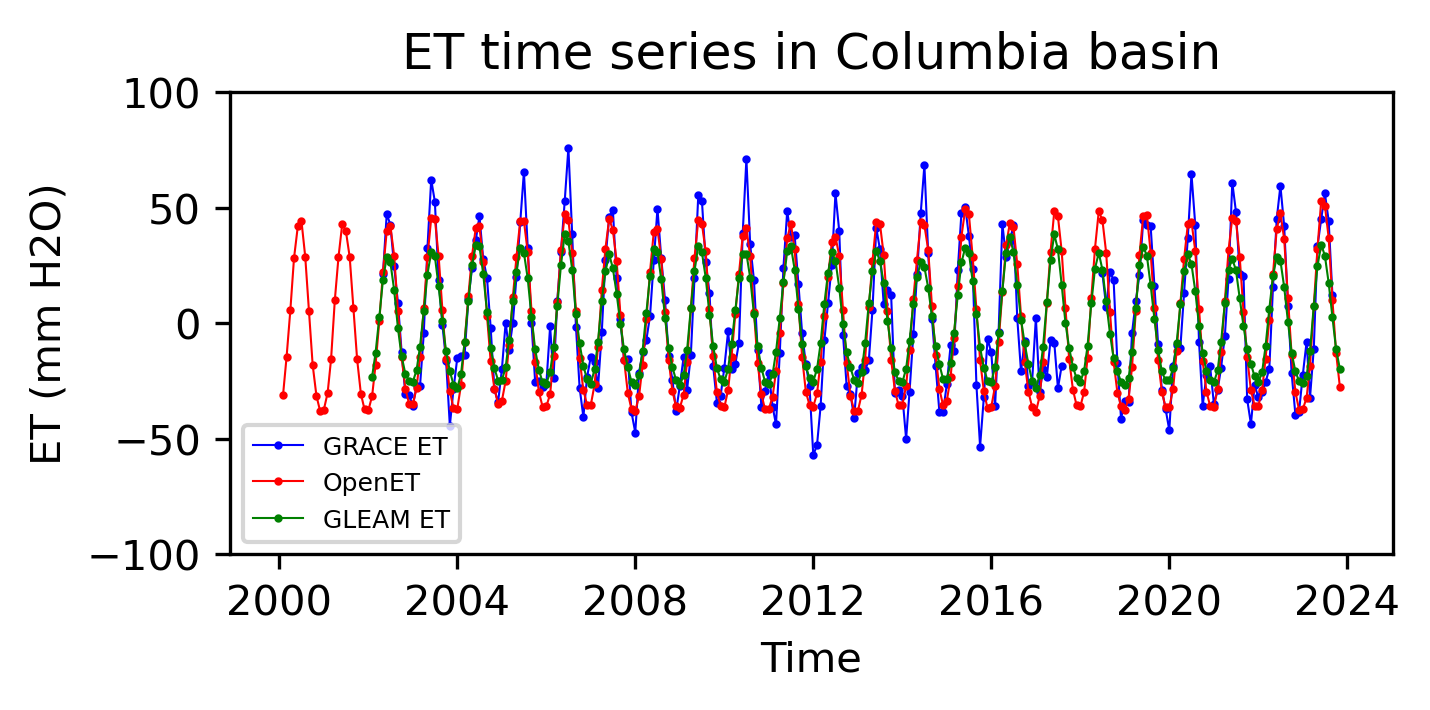

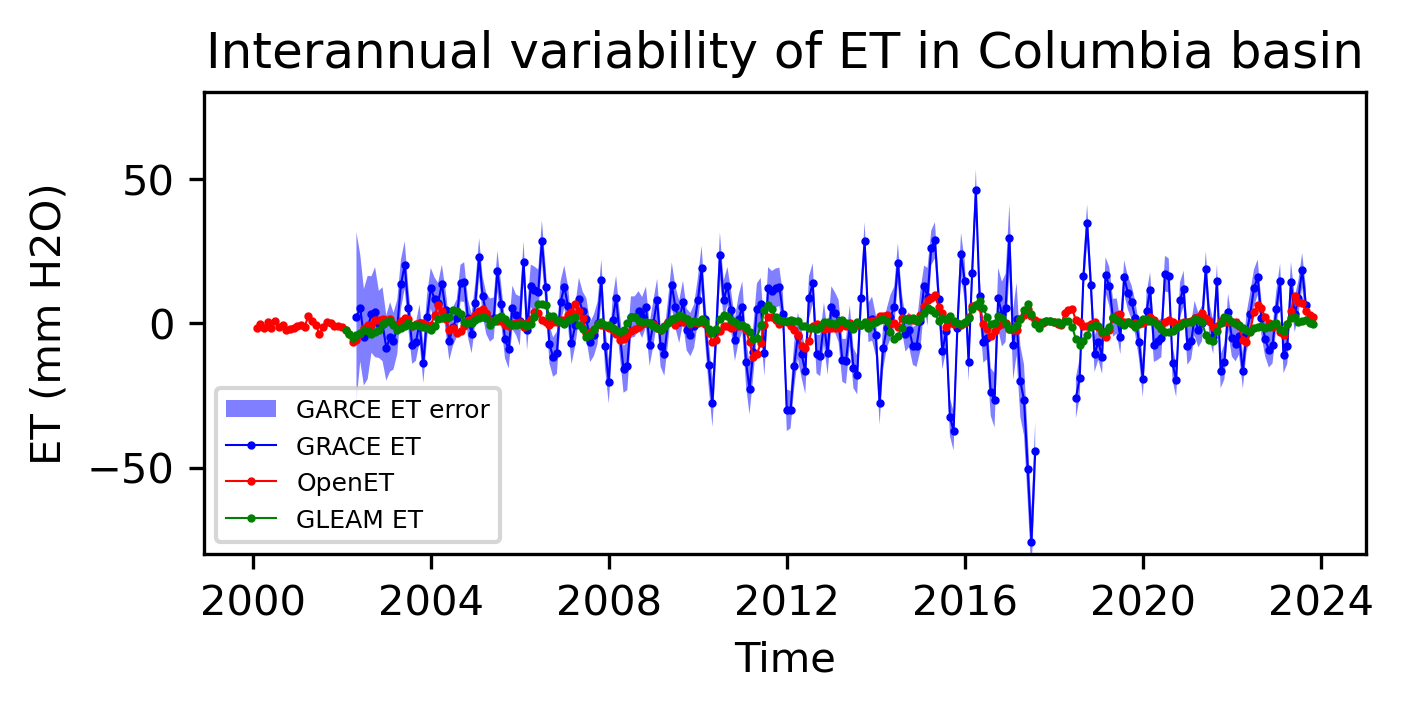

In [17]:
## This function caluculte the interannual variability by subextract the long-term mean of each month
def interannual(ts):
    rshp = ts.groupby([ts.index.year,ts.index.strftime('%m')],dropna=False).mean().unstack()
    annual = rshp.mean(axis=1,skipna=True)
    climatology = rshp.mean(axis=0,skipna=True)
    deseason = (rshp - climatology).T.unstack()
    start_yr = ts.index[0].year
    end_yr = ts.index[-1].year
    deseason = pd.Series(deseason.values,index=pd.date_range(start=pd.to_datetime('{0:04d}-1-1'.format(start_yr)), \
                                                    periods=len(deseason.values), freq='MS')) 
    return deseason

GRACEET = ET_basin
GRACEET_error = ET_error
GRACEET_IAV = interannual(GRACEET)
GRACEET_IAV = GRACEET_IAV[GRACEET_error.index]

df = pd.read_csv('Columbia.csv')
OpenET = pd.Series(np.array(df['mean']),pd.to_datetime(df['Date'])).rolling(window=3, center=True).mean()
OpenET_IAV = interannual(OpenET)

GLEAMET = read_gleam(allbasinmask)
GLEAMET_IAV = interannual(GLEAMET)

## plot the GRACE based ET and OpenET before removing seasonal cycle
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-100,100)  #100
plt.plot(GRACEET-np.mean(GRACEET),'-ob',markersize=1,linewidth=0.5, label='GRACE ET')
plt.plot(OpenET-np.mean(OpenET),'-or',markersize=1,linewidth=0.5,label='OpenET')
plt.plot(GLEAMET-np.mean(GLEAMET),'-og',markersize=1,linewidth=0.5,label='GLEAM ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('ET time series in Columbia basin')

## plot the interannual veriability of GRACE based ET and OpenET
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-80,80) #80
yerr = np.array(GRACEET_error)
plt.fill_between(GRACEET_IAV.index, np.array(GRACEET_IAV) - yerr, np.array(GRACEET_IAV) + yerr, color='blue', edgecolor='none', alpha=0.5, label='GARCE ET error')
plt.plot(GRACEET_IAV,'-ob',markersize=1,linewidth=0.5, label='GRACE ET')
#plt.plot(GRACEET1.rolling(window=5, center=True).mean(),'-ob',markersize=1,linewidth=0.5, label='GRACE based ET')
plt.plot(OpenET_IAV,'-or',markersize=1,linewidth=0.5,label='OpenET')
plt.plot(GLEAMET_IAV,'-og',markersize=1,linewidth=0.5,label='GLEAM ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Interannual variability of ET in Columbia basin')


#### Calculate the R2 metric between ET_GRACE/FO and other products

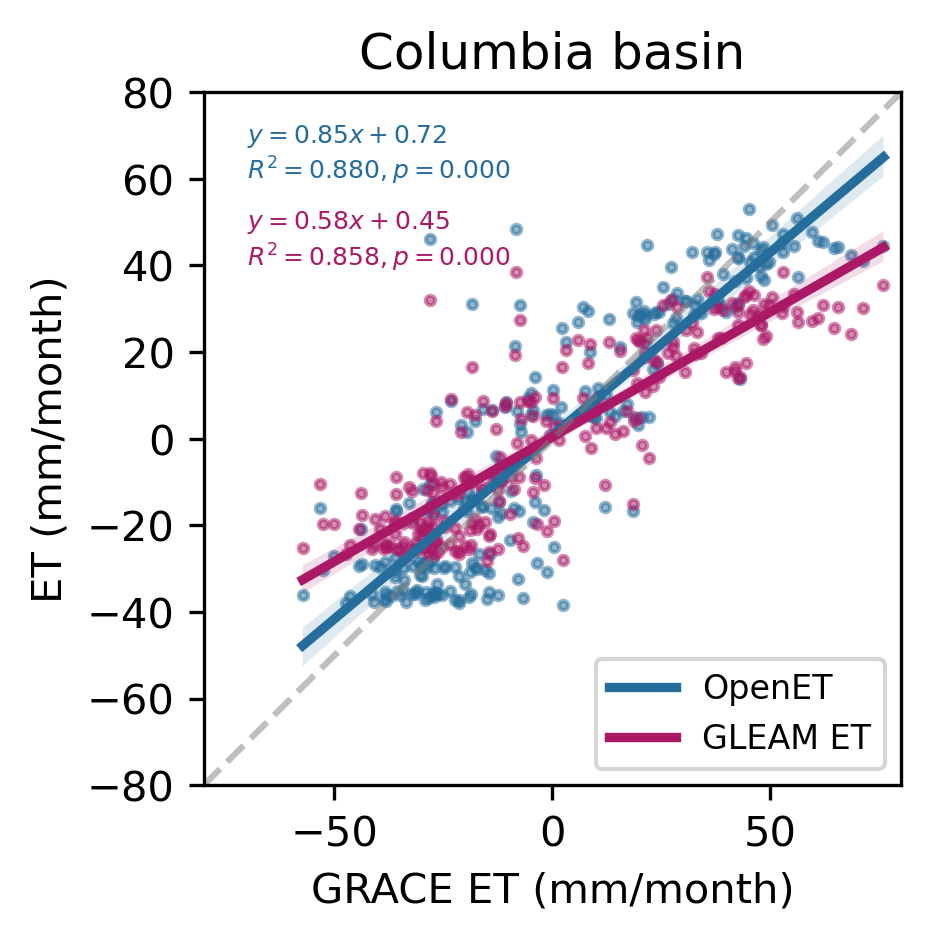

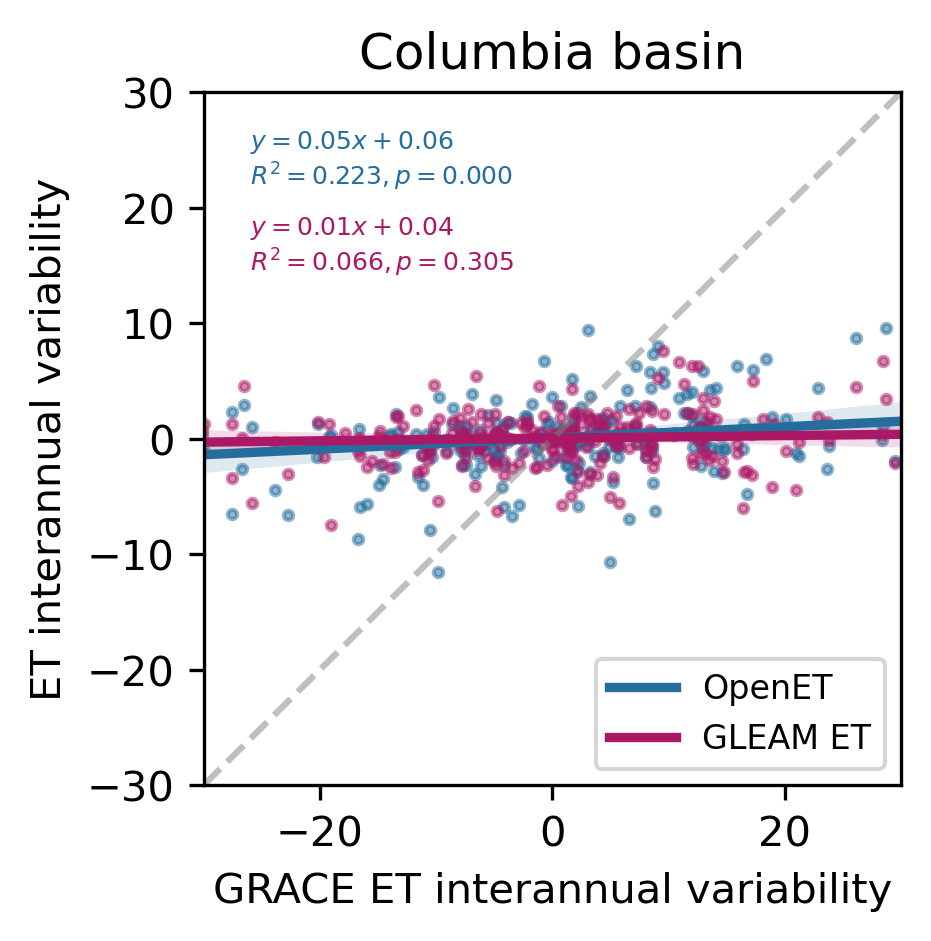

In [19]:
import seaborn as sns
from scipy.stats import linregress

## merge these time series in one dataframe
df = pd.DataFrame({'Date':GRACEET.index,'GraceET':np.array(GRACEET)-np.nanmean(np.array(GRACEET))})
df1 = pd.DataFrame({'Date':GRACEET_IAV.index,'GraceET_IAV':np.array(GRACEET_IAV)})
df2 = pd.DataFrame({'Date':OpenET.index,'OpenET':np.array(OpenET)-np.nanmean(np.array(OpenET))})
df3 = pd.DataFrame({'Date':OpenET_IAV.index,'OpenET_IAV':np.array(OpenET_IAV)})
df4 = pd.DataFrame({'Date':GLEAMET.index,'GLEAMET':np.array(GLEAMET)-np.nanmean(np.array(GLEAMET))})
df5 = pd.DataFrame({'Date':GLEAMET_IAV.index,'GLEAMET_IAV':np.array(GLEAMET_IAV)})
merge_df = pd.merge(df, df1, on='Date')
merge_df = pd.merge(merge_df,df2, on='Date')
merge_df = pd.merge(merge_df,df3, on='Date')
merge_df = pd.merge(merge_df,df4, on='Date')
merge_df = pd.merge(merge_df,df5, on='Date')
merge_df.dropna(axis=0,inplace=True)

## difine two colors
opencolor = (36/255,109/255,156/255)
gleamcolor = (171/255,24/255,102/255)

## make the scatter and linear regression plot for full time series
ylim=80
plt.figure(figsize=(3,3),dpi=300)
slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['GraceET'], y=merge_df['OpenET'])
sns.regplot(x='GraceET', y='OpenET', data=merge_df, ci = 99, line_kws={"color": opencolor,"label":'OpenET'}, scatter_kws={"alpha": 0.5,"color": opencolor,"s":5})
sns.regplot(x='GraceET', y='GLEAMET', data=merge_df, ci = 99, line_kws={"color": gleamcolor,"label":'GLEAM ET'}, scatter_kws={"alpha": 0.5,"color":gleamcolor,"s":5})
plt.ylim(-ylim, ylim) 
plt.xlim(-ylim, ylim) 
plt.plot([-ylim,ylim], [-ylim,ylim], linestyle='--', color='gray', alpha=0.5)
plt.xlabel('GRACE ET (mm/month)')
plt.ylabel('ET (mm/month)')
plt.text(-ylim+10, ylim-20, #20
        f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
        fontsize=6, color=opencolor)
slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['GraceET'], y=merge_df['GLEAMET'])
plt.text(-ylim+10, ylim-40,  #40
        f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
        fontsize=6, color=gleamcolor)
plt.title('Columbia basin')
plt.legend(fontsize=8,loc=4)


## make the scatter and linear regression plot for interannual variability
plt.figure(figsize=(3,3),dpi=300)
slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['GraceET_IAV'], y=merge_df['OpenET_IAV'])
sns.regplot(x='GraceET_IAV', y='OpenET_IAV', data=merge_df, ci = 99, line_kws={"color": opencolor,"label":'OpenET'}, scatter_kws={"alpha": 0.5,"color": opencolor,"s":5})
sns.regplot(x='GraceET_IAV', y='GLEAMET_IAV', data=merge_df, ci = 99, line_kws={"color": gleamcolor,"label":'GLEAM ET'}, scatter_kws={"alpha": 0.5,"color":gleamcolor,"s":5})
plt.ylim(-30, 30) 
plt.xlim(-30, 30) 
plt.plot([-30, 30], [-30, 30], linestyle='--', color='gray', alpha=0.5)
plt.xlabel('GRACE ET interannual variability')
plt.ylabel('ET interannual variability')
plt.text(-26, 22, 
        f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
        fontsize=6, color=opencolor)
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x=merge_df['GraceET_IAV'], y=merge_df['GLEAMET_IAV'])
plt.text(-26, 14.5, 
        f"$y = {slope1:.2f}x + {intercept1:.2f}$\n$R^2 = {r_value1:.3f}, p = {p_value1:.3f}$", 
        fontsize=6, color=gleamcolor)
plt.title('Columbia basin')
plt.legend(fontsize=8,loc=4)

#### Generate 1000 Monte Carlo simulations within the uncertainty of ET_GRACE

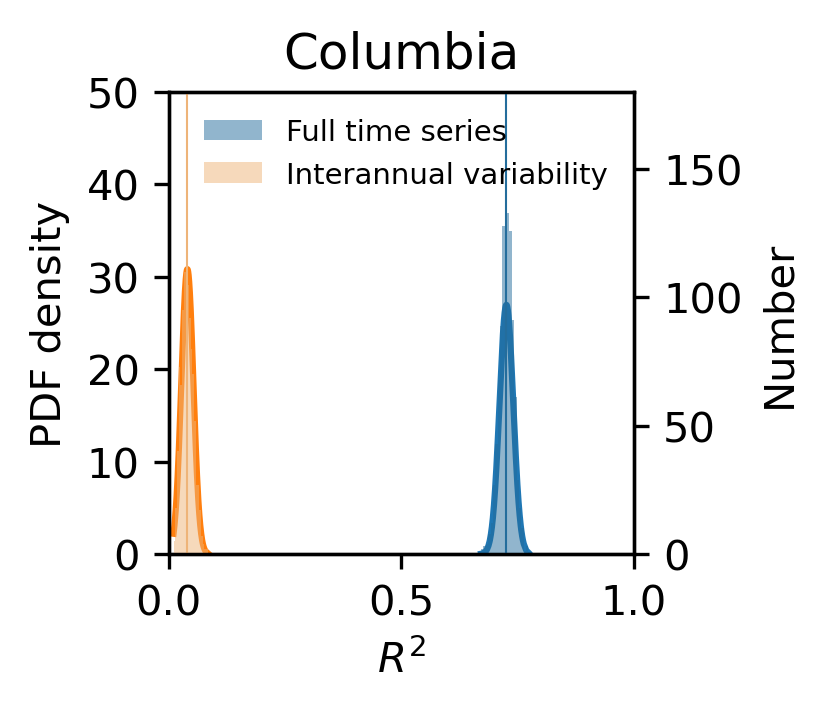

In [20]:
import statsmodels.api as smpk
from scipy.stats import norm

## Save all the R2 for 1000 Monte Carlo simulations of ET_GRACE and OpenET
fake_r2 = []
fake_r2_z = []

GRACEET = GRACEET[OpenET.index]
GRACEET_error = GRACEET_error[OpenET.index]
#plt.figure(figsize=(5,2),dpi=300)
for i in range(1000):
    fake_GRACEET_ts = pd.Series(np.random.normal(loc=GRACEET, scale=GRACEET_error),\
                        index = GRACEET.index)
    #plt.plot(fake_GRACEET_ts,'-k')

    mod = smpk.OLS(fake_GRACEET_ts.values, smpk.add_constant(np.column_stack([\
                            OpenET[GRACEET.index].values
                            ])),missing='drop').fit()

    fake_r2.append(mod.rsquared)
#plt.figure(figsize=(5,2),dpi=300)
for i in range(1000):
    fake_GRACEET_ts = pd.Series(np.random.normal(loc=GRACEET, scale=GRACEET_error),\
                        index = GRACEET.index)
    fake_GRACEET_z = interannual(fake_GRACEET_ts)[GRACEET.index]
    #plt.plot(fake_GRACEET_z,'-k')

    mod = smpk.OLS(fake_GRACEET_z.values, smpk.add_constant(np.column_stack([\
                            OpenET_IAV[GRACEET.index].values
                            ])),missing='drop').fit()

    fake_r2_z.append(mod.rsquared)



gracecolor = (36/255,109/255,156/255)
gracecolor1 = (238/255,180/255,121/255)

## Plot the 1000 R2 distribution and possibility distribution curve
fig,ax1 = plt.subplots(figsize=(2,2),dpi=300)  
#plt.figure(figsize=(2,2),dpi=300)
ax1.set_ylim(0,50)
ax1.set_xlim(0,1)
ax1.set_title('Columbia')
ax1.set_xlabel('$R^2$')
ax1.set_ylabel('PDF density')

df_mean = np.mean(fake_r2)
df_std = np.std(fake_r2)
pdf = norm.pdf(pd.Series(fake_r2).sort_values(), df_mean, df_std)
ax1.plot(pd.Series(fake_r2).sort_values(), pdf)
df_mean = np.mean(fake_r2_z)
df_std = np.std(fake_r2_z)
pdf = norm.pdf(pd.Series(fake_r2_z).sort_values(), df_mean, df_std)
ax1.plot(pd.Series(fake_r2_z).sort_values(), pdf)

ax2 = ax1.twinx()
ax2.set_ylabel('Number')
ax2.set_ylim(0,180)
ax2.hist(fake_r2,bins=20, color=gracecolor, alpha=0.5,label='Full time series')
ax2.hist(fake_r2_z,bins=20, color=gracecolor1, alpha=0.5,label='Interannual variability')
ax2.plot([np.mean(fake_r2),np.mean(fake_r2)],[0,180],'-',color=gracecolor,linewidth=0.5)
ax2.plot([np.mean(fake_r2_z),np.mean(fake_r2_z)],[0,180],'-',color=gracecolor1,linewidth=0.5)
plt.legend(fontsize=7,frameon=False)

## 3. Compare the IAV of ET at the site scale, an example of US-Me2 site from AmeriFlux dataset

In [21]:
## This function is for getting interannual variability, it can fix the missing value problem. 
def interannual(ts):
    rshp = ts.groupby([ts.index.year,ts.index.strftime('%m')],dropna=False).mean().unstack()
    annual = rshp.mean(axis=1,skipna=True)
    climatology = rshp.mean(axis=0,skipna=True)
    deseason = (rshp - climatology).T.unstack()
    
    date = [pd.NaT] * len(deseason)
    for i in range(len(deseason)):
        date[i] = pd.to_datetime('{0:04d}-{1:02d}-1'.format(*[deseason.index[i][0],int(deseason.index[i][1])]))

    start_yr = ts.index[0].year
    end_yr = ts.index[-1].year
    deseason = pd.Series(deseason.values,index=date) 
    return deseason

In [22]:
## Load the OpenET at each AmeriFlux site

## This data is downlaoded from (Volk et al., 2024), they extracted the OpenET time series for each AmeriFlux site. 
## https://zenodo.org/records/7636781
path = 'monthly_data.dat'
df = pd.read_csv(path, delimiter='\t', encoding='utf-8',skiprows=3)
site = df['Site ID']
site_len = np.zeros(len(site.unique()))*np.nan
inter_ensemble = np.zeros(len(site))*np.nan
OpenET = pd.Series(np.array(df['Ensemble']),pd.to_datetime(df['DATE']))
i=0
for name in site.unique():
    tmp = OpenET.iloc[np.where(site==name)]
    site_len[i] = np.sum(site==name)
    inter_tmp = interannual(tmp).dropna()
    inter_ensemble[np.where(site==name)] = inter_tmp
    i=i+1
df['inter_Ensemble'] = inter_ensemble

In [24]:
## This function read the OpenET, AmeriFlux ET and GLEAM ET at the 'US-Me2' site
def three_ET(name,ylim1,ylim2,ylim3,ylim4):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    from scipy.stats import linregress

    ## Read the OpenET time series at 'US-Me2' site, get the IAV of OpenET
    Open = pd.Series(np.array(df['Ensemble']),pd.to_datetime(df['DATE'])).iloc[np.where(site==name)]
    Open = Open.resample("MS").asfreq()
    Open = Open.interpolate(method="time")
    Open1 = interannual(Open)

    ## This file is the AmeriFlux ET time series on the 'US-Me2' site
    filepath = 'US-Me2_monthly_data.csv'
    df2 = pd.read_csv(filepath, delimiter=",")
    Ameri = pd.Series(np.array(df2['ET_corr']),pd.to_datetime(df2['date']))
    Ameri.index = Ameri.index.to_period('M').to_timestamp()
    Ameri = Ameri.interpolate(method="time")
    Ameri1 = interannual(Ameri)

    ## This file is the GLEAM ET time series on the 'US-Me2' site
    filepath = 'amf-stations_gleam42a_mm-month1.csv'
    df2 = pd.read_csv(filepath, delimiter=",")
    gleam = pd.Series(np.array(df2[name]),pd.to_datetime(df2['Date']))[240:]
    gleam1 = interannual(gleam)


    ## merge these time series in one dataframe by the date
    df3 = pd.DataFrame({'Date':Open.index,'OpenET':np.array(Open)-np.mean(Open)})
    merge_df = pd.merge(df3, pd.DataFrame({'Date':Open1.index,'OpenET_inter':np.array(Open1)}), on='Date')
    merge_df = pd.merge(merge_df,pd.DataFrame({'Date':Ameri.index,'AmeriET':np.array(Ameri)-np.mean(Ameri)}), on='Date')
    merge_df = pd.merge(merge_df,pd.DataFrame({'Date':Ameri1.index,'AmeriET_inter':np.array(Ameri1)}), on='Date')
    merge_df = pd.merge(merge_df,pd.DataFrame({'Date':gleam.index,'GLEAMET':np.array(gleam)}), on='Date')
    merge_df = pd.merge(merge_df,pd.DataFrame({'Date':gleam1.index,'GLEAMET_inter':np.array(gleam1)}), on='Date')

    ## Plot the full time series
    plt.figure(figsize=(5,2),dpi=300)
    plt.ylim(-100,150)  #100
    plt.plot(Open-np.mean(Open),'-ob',markersize=1,linewidth=0.5, label='OpenET')
    plt.plot(Ameri-np.mean(Ameri),'-or',markersize=1,linewidth=0.5,label='Ameriflux ET')
    plt.plot(gleam-np.mean(gleam),'-og',markersize=1,linewidth=0.5,label='GLEAM ET')
    plt.legend(fontsize=6)
    plt.xlabel('Time')
    plt.ylabel('ET (mm H2O)')
    plt.title('ET time series in '+name+' site')

    ## Plot the interannual variability of ET time series
    plt.figure(figsize=(5,2),dpi=300)
    plt.ylim(-100,150)  #100
    plt.plot(Open1-np.mean(Open1),'-ob',markersize=1,linewidth=0.5, label='OpenET')
    plt.plot(Ameri1-np.mean(Ameri1),'-or',markersize=1,linewidth=0.5,label='Ameriflux ET')
    plt.plot(gleam1-np.mean(gleam1),'-og',markersize=1,linewidth=0.5,label='GLEAM ET')
    plt.legend(fontsize=6)
    plt.xlabel('Time')
    plt.ylabel('ET (mm H2O)')
    plt.title('ET time series in '+name+' site')

    opencolor = (36/255,109/255,156/255)
    gleamcolor = (171/255,24/255,102/255)


    ## Calculate the R^2 for full time series and make the scatter and linear regression figure
    import seaborn as sns
    from scipy.stats import linregress
    plt.figure(figsize=(4,4),dpi=300)
    slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['AmeriET'], y=merge_df['OpenET'])
    sns.regplot(x='AmeriET', y='OpenET', data=merge_df, ci=99, line_kws={"color": opencolor,"label":'OpenET'}, scatter_kws={"alpha": 0.5,"color": opencolor,"s":5})
    sns.regplot(x='AmeriET', y='GLEAMET', data=merge_df, ci=99, line_kws={"color": gleamcolor,"label":'GLEAM ET'}, scatter_kws={"alpha": 0.5,"color": gleamcolor,"s":5})

    plt.ylim(-ylim1, ylim2) 
    plt.xlim(-ylim1, ylim2) 
    plt.plot([-ylim1,ylim2], [-ylim1,ylim2], linestyle='--', color='gray', alpha=0.5)
    plt.xlabel('AmeriFlux ET (mm)')
    plt.ylabel('ET (mm)')
    plt.text(-ylim1+0.05*(ylim1+ylim2),-ylim1+0.9*(ylim1+ylim2), #30
                f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
                fontsize=8, color=opencolor)
    slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['AmeriET'], y=merge_df['GLEAMET'])
    plt.text(-ylim1+0.05*(ylim1+ylim2),-ylim1+0.75*(ylim1+ylim2),   #70
                f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
                fontsize=8, color=gleamcolor)
    plt.title(name)
    plt.legend(fontsize=10,loc=4)


     ## Calculate the R^2 for interannual variability and make the scatter and linear regression figure
    plt.figure(figsize=(4,4),dpi=300)
    slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['AmeriET_inter'], y=merge_df['OpenET_inter'])
    sns.regplot(x='AmeriET_inter', y='OpenET_inter', data=merge_df, ci = 99, line_kws={"color": opencolor,"label":'OpenET'}, scatter_kws={"alpha": 0.5,"color": opencolor,"s":5})
    sns.regplot(x='AmeriET_inter', y='GLEAMET_inter', data=merge_df, ci = 99, line_kws={"color": gleamcolor,"label":'GLEAM ET'}, scatter_kws={"alpha": 0.5,"color": gleamcolor,"s":5})

    plt.ylim(-ylim3, ylim4) 
    plt.xlim(-ylim3, ylim4) 
    plt.plot([-ylim3, ylim4], [-ylim3, ylim4], linestyle='--', color='gray', alpha=0.5)
    plt.xlabel('AmeriFlux ET interannual variability (mm)')
    plt.ylabel('ET interannual variability (mm)')
    plt.text(-ylim3+0.05*(ylim3+ylim4),-ylim3+0.9*(ylim3+ylim4), 
                f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
                fontsize=8, color=opencolor)
    slope, intercept, r_value, p_value, std_err = linregress(x=merge_df['AmeriET_inter'], y=merge_df['GLEAMET_inter'])
    plt.text(-ylim3+0.05*(ylim3+ylim4),-ylim3+0.75*(ylim3+ylim4),
                f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value:.3f}, p = {p_value:.3f}$", 
                fontsize=8, color=gleamcolor)
    plt.title(name)
    plt.legend(fontsize=10,loc=4)


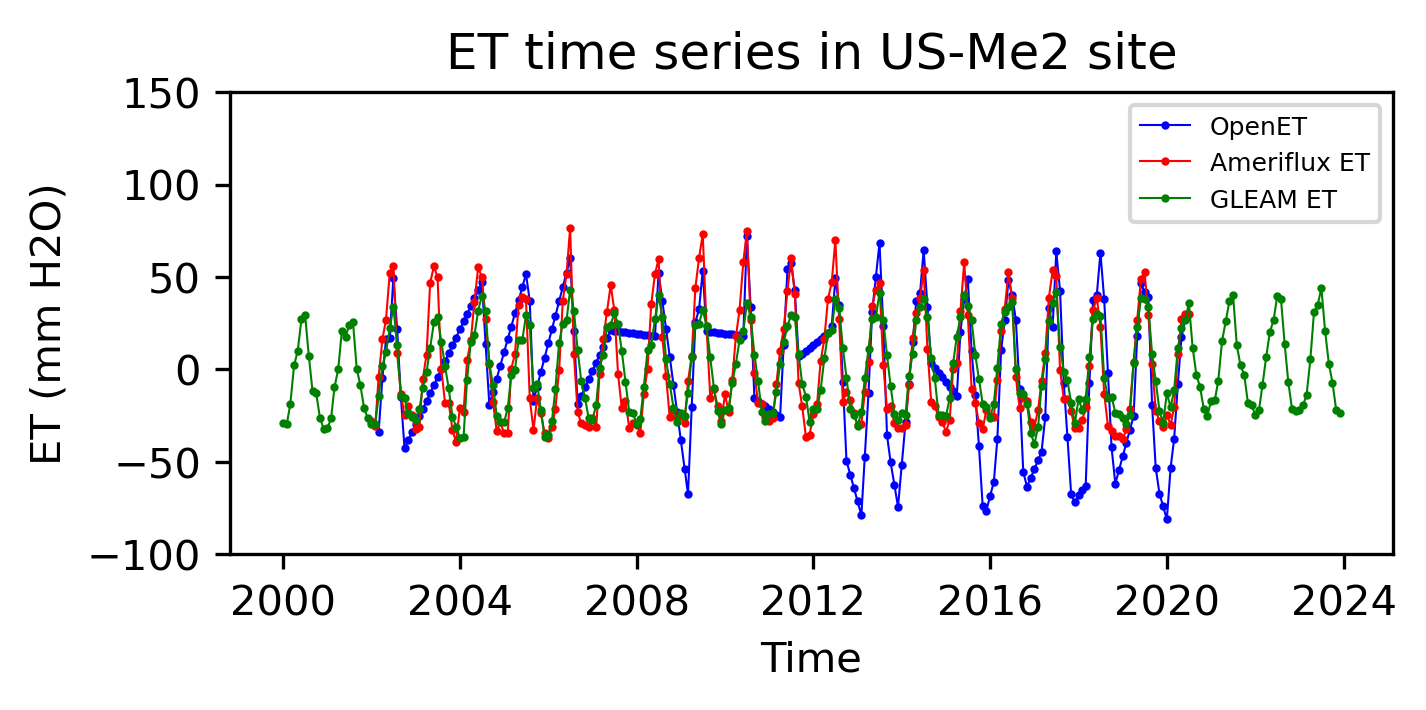

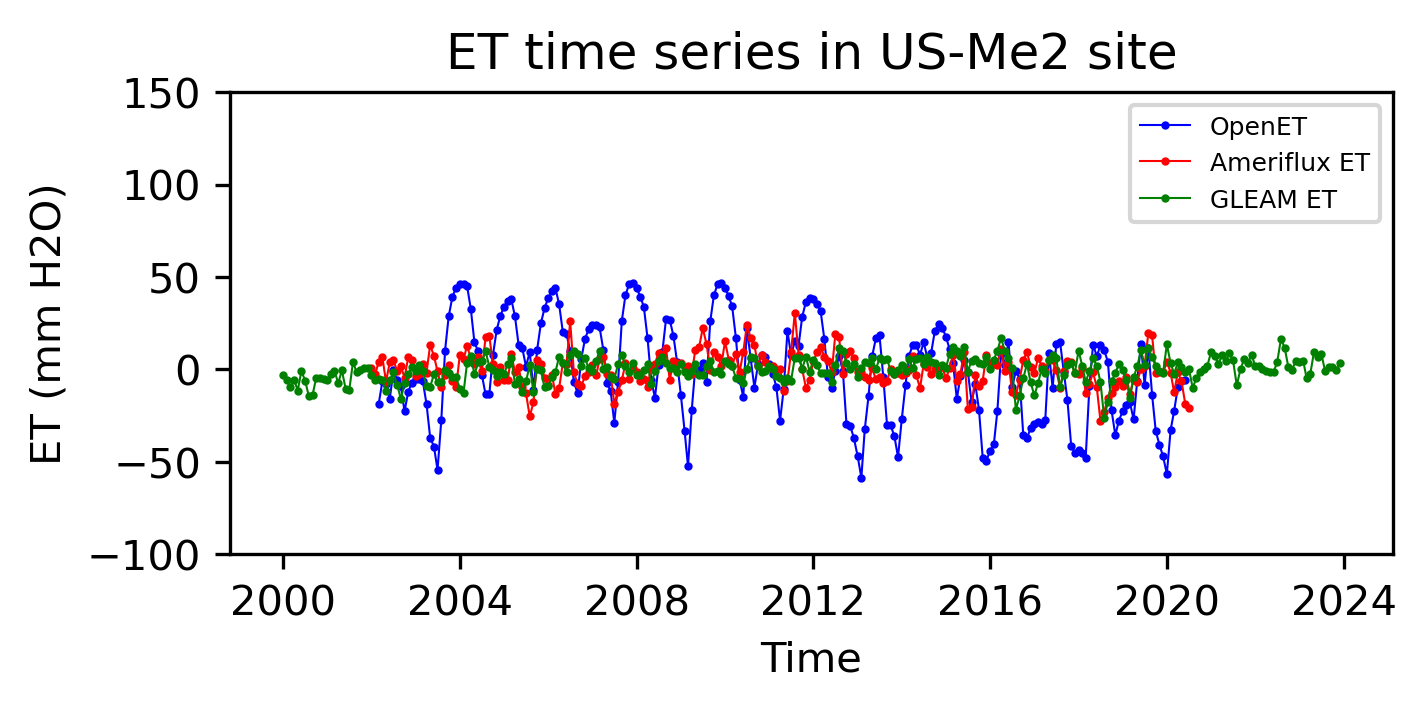

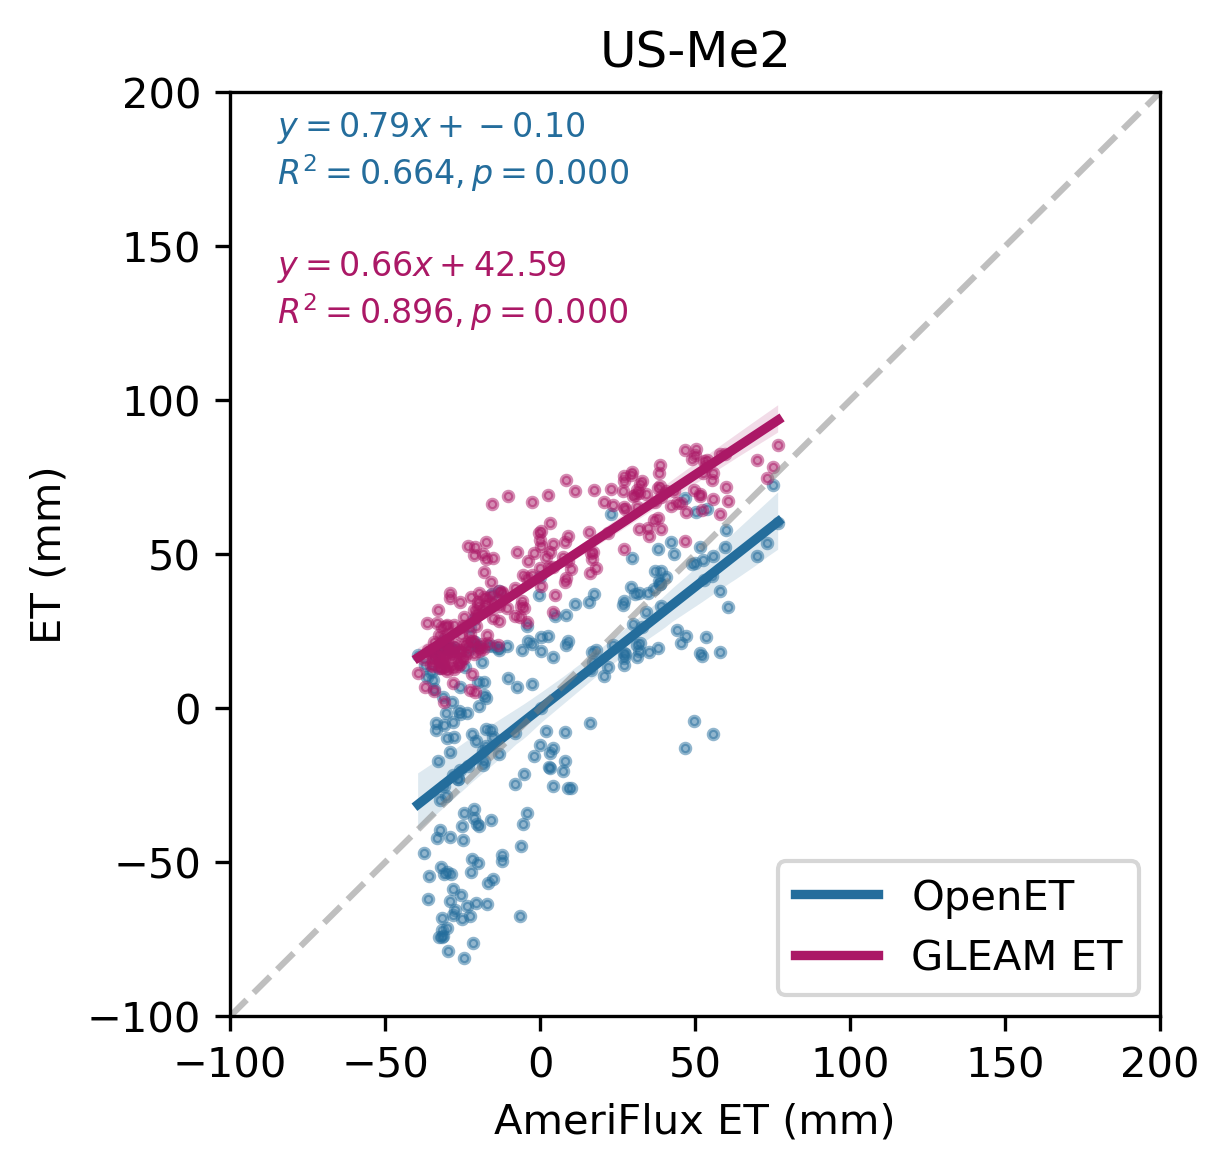

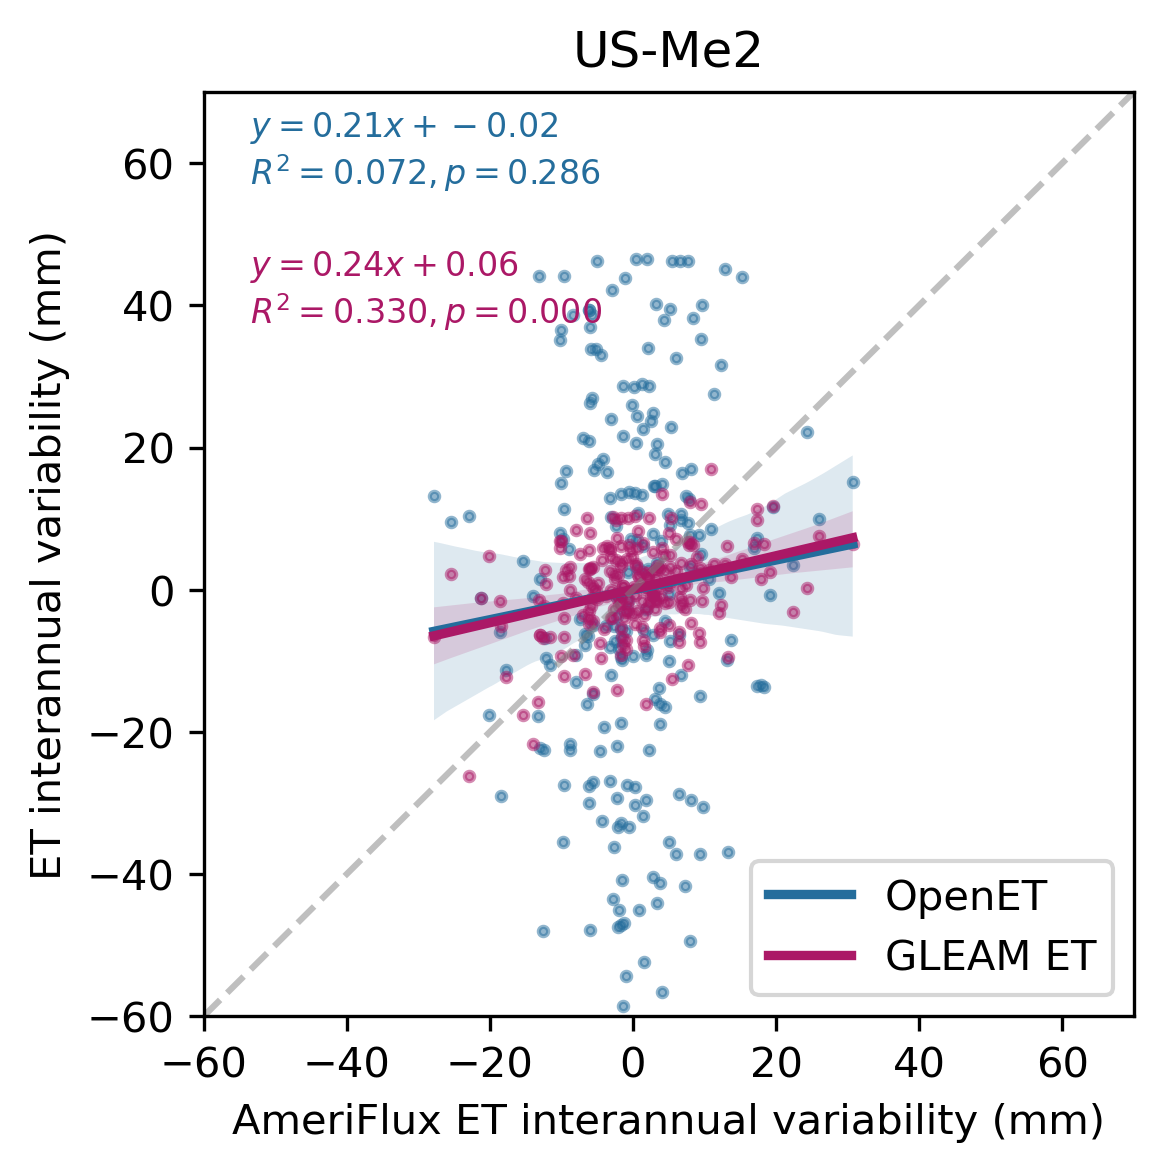

In [25]:
## call the function using the input of site name, the latter four parameters are adjustable for different sites based on the actual value.
three_ET('US-Me2',100,200,60,70)